# Replikation und Erweiterung von Figure 5 ("Understanding Transformers via N-Gram Statistics")

Dieses Notebook dient der Nachbildung und Erweiterung von **Figure 5** aus dem Paper  
**"Understanding Transformers via N-Gram Statistics"** von Timothy Nguyen (Google DeepMind).

## Inhalt des Notebooks:

### 1. Vorarbeit: Laden und Analyse der N-Gramm-Statistiken  
- Erhebung eigener N-Gramm-Statistiken aus dem TinyStories-Datensatz  
- Vergleich mit offiziellen N-Gramm-Verteilungen zur Validierung der Methodik

### 2. Replikation von Figure 5  
- Nutzung der berechneten N-Gramm-Häufigkeiten zur Reproduktion der Ergebnisse und Visualisierungen aus Figure 5 des Papers  
- Interpretation und Vergleich der Resultate mit denen des Originalpapers

## Referenzen:
- Original-Paper: [Understanding Transformers via N-Gram Statistics (Nguyen, DeepMind)](https://arxiv.org/pdf/2407.12034)  
- Datensatz: [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories)



Geladen: 8750 Zeilen aus 7 Dateien.
Beispielhafte 1-Gramme: [('each',), ('shared',), ('share',), (',',), ('said',)]
Beispielhafte 2-Gramme: [('each', 'shared'), ('shared', 'share'), ('share', ','), (',', 'said'), ('said', 'difficult')]
Beispielhafte 3-Gramme: [('each', 'shared', 'share'), ('shared', 'share', ','), ('share', ',', 'said'), (',', 'said', 'difficult'), ('said', 'difficult', 'was')]
Beispielhafte 4-Gramme: [('each', 'shared', 'share', ','), ('shared', 'share', ',', 'said'), ('share', ',', 'said', 'difficult'), (',', 'said', 'difficult', 'was'), ('said', 'difficult', 'was', 'found')]
Beispielhafte 5-Gramme: [('each', 'shared', 'share', ',', 'said'), ('shared', 'share', ',', 'said', 'difficult'), ('share', ',', 'said', 'difficult', 'was'), (',', 'said', 'difficult', 'was', 'found'), ('said', 'difficult', 'was', 'found', 'because')]
Beispielhafte 6-Gramme: [('each', 'shared', 'share', ',', 'said', 'difficult'), ('shared', 'share', ',', 'said', 'difficult', 'was'), ('share', ',

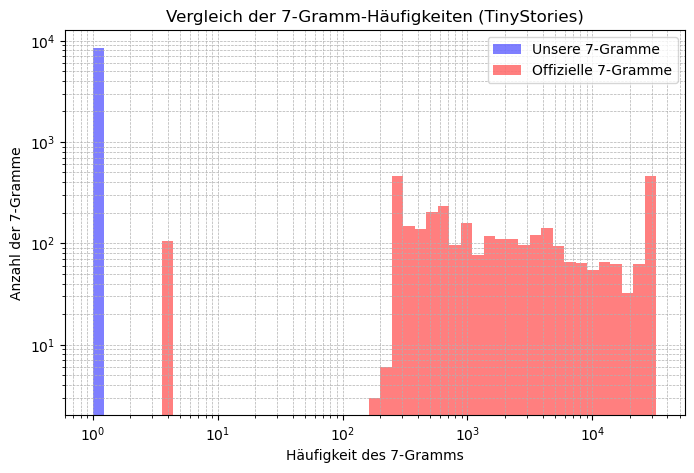

In [60]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gcsfs
from typing import List, Tuple
import dask.dataframe as dd

# Google Cloud Storage Einstellungen
GCS_BUCKET = 'gs://transformer-ngrams/TinyStories/train_data_rules'
fs = gcsfs.GCSFileSystem()


# N-Gramme aus Tokenliste erzeugen
def extract_ngrams(tokens: List[str], n: int) -> List[Tuple[str, ...]]:
    '''Erzeugt N-Gramme (Tupel aus n Tokens) aus einer gegebenen Tokenliste.'''
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]


#Corpus in überlappende Abschnitte teilen
def chunk_dataset(corpus: List[str], chunk_size: int = 2048, step: int = None) -> List[List[str]]:
    """
    Teilt Tokens in überlappende Chunks. Falls das Corpus kleiner als `chunk_size` ist,
    wird automatisch die gesamte Länge als Chunk verwendet.
    """
    if step is None:
        step = chunk_size // 2  # Standardmäßig 50% Overlap

    chunk_size = min(chunk_size, len(corpus))  # Falls zu wenig Tokens da sind, anpassen
    if len(corpus) < chunk_size:
        print("Hinweis: Corpus ist kleiner als gewünschte Chunk-Größe. Verwende vollständigen Text.")
        return [corpus]  # Rückgabe eines einzigen Chunks mit allen Tokens

    return [corpus[i:i + chunk_size] for i in range(0, len(corpus) - chunk_size + 1, step)]


# Zähle N-Gramme für n=1 bis n = 7
def compute_ngram_statistics(official_data: List[List[str]], max_n: int = 7):
    '''Berechnet Häufigkeiten für N-Gramme (n=1 bis max_n) über gegebene Chunks und zeigt die Top 10 pro n.'''

    ngram_counts = collections.defaultdict(collections.Counter)

    for chunk in official_data:
        for n in range(1, max_n + 1):
            ngrams = extract_ngrams(chunk, n)
            print(f"Beispielhafte {n}-Gramme aus einem Chunk:", ngrams[:5])
            for ngram in ngrams:
                ngram_counts[n][ngram] += 1  

    # Zeigt die Top 10 häufigsten N-Gramme
    for n in range(1, 8):
        print(f"Top 10 der : {n}-Gramme mit Häufigkeiten:", ngram_counts[n].most_common(10))
    print("Erfasste N-Gramm-Stufen:", list(ngram_counts.keys()))
    return ngram_counts



# Speichert N-Gramm-Häufigkeiten in JSON
def store_ngram_statistics_json(ngram_counts, filename="ngrams.json"):
    '''Speichert berechnete N-Gramm-Häufigkeiten als JSON-Datei, in der jedes N-Gramm als String gespeichert wird.'''

    json_data = {
        str(n): {" ".join(ngram): count for ngram, count in counts.items()} 
        for n, counts in ngram_counts.items()
    }
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4)


'''def load_all_official_data():
    file_list = fs.ls(GCS_BUCKET)
    df_list = []

    for file in file_list:
        if file.endswith(".parquet"):
            with fs.open(file) as f:
                df = pd.read_parquet(f, engine="pyarrow")
                df_list.append(df)

    if df_list:
        official_ngram_data = pd.concat(df_list, ignore_index=True)
        print(f"Gesamte Daten geladen: {len(official_ngram_data)} Zeilen aus {len(file_list)} Dateien.")
        return official_ngram_data
    else:
        print("Keine Daten geladen!")
        return None'''



# Lädt eine kleine Stichprobe der offiziellen Daten
def load_small_sample_from_official_data(sample_fraction=0.20, max_files=6, max_rows=5000):
    '''Lädt eine Stichprobe der offiziellen N-Gramm-Daten aus Parquet-Dateien in Google Cloud Storage.'''

    file_list = fs.ls(GCS_BUCKET)[:max_files]  # Lädt nur die ersten max_files Dateien
    df_list = []

    
    for file in file_list:
        if file.endswith(".parquet"):
            with fs.open(file) as f:
                df = pd.read_parquet(f, engine="pyarrow")
                
                # Begrenze Zeilenanzahl
                if len(df) > max_rows:
                    df = df.sample(n=max_rows, random_state=42)
                
                df_sample = df.sample(frac=sample_fraction, random_state=42)
                df_list.append(df_sample)
    
    if df_list:
        official_ngram_sample = pd.concat(df_list, ignore_index=True)
        print(f"Geladen: {len(official_ngram_sample)} Zeilen aus {len(file_list)} Dateien.")
        return official_ngram_sample
    else:
        print("Keine Daten geladen!")
        return None



# Lade unsere berechneten N-Gramm-Statistiken aus JSON
def load_computed_ngram_data(filename="ngrams.json"):
    '''Lädt lokal gespeicherte, eigene N-Gramm-Häufigkeiten aus einer JSON-Datei.'''

    try:
        with open(filename, "r", encoding="utf-8") as f:
            data = json.load(f)

        print(f"DEBUG: Geladene Daten aus {filename}: {list(data.keys())[:5]}")  # Zeigt die Schlüssel an
        print(f"DEBUG: Beispiel für gespeicherte 7-Gramme:", list(data.get("7", {}).items())[:10])  

        return data

    except FileNotFoundError:
        print(f"Fehler: Datei '{filename}' nicht gefunden!")
        return None


# Vergleich der 7-Gramm-Häufigkeiten mit den offiziellen Daten
def compare_ngram_distributions(ngram_counts):
    '''Vergleicht eigene berechnete 7-Gramm-Häufigkeiten mit offiziellen Häufigkeiten, erzeugt ein Histogramm zur Verteilung.'''

    print("DEBUG: Typ von ngram_counts in compare_ngram_distributions:", type(ngram_counts))
    print("DEBUG: Beispielhafte Einträge in compare_ngram_distributions:", list(ngram_counts.items())[:5])

    official_data = load_small_sample_from_official_data()
    if official_data is None:
        print("Fehler: Keine offiziellen Daten verfügbar!")
        return
    
    computed_data = load_computed_ngram_data()
    print("DEBUG: Geladene Daten aus ngrams.json:", list(computed_data.keys()))
    if computed_data is None:
        print("Fehler: Berechnete N-Gramm-Daten nicht verfügbar!")
        return
    
    n = 7
    if "context_size_used" not in official_data.columns or "target" not in official_data.columns:
        print("Fehler: Erwartete Spalten fehlen in den offiziellen Daten!")
        print("Vorhandene Spalten:", official_data.columns)
        return
    
    official_counts = official_data[official_data['context_size_used'] == n]['target'].values
    computed_counts = [count for count in ngram_counts[7].values()]
    print("Häufigkeitsverteilung der 7-Gramme:")
    print(f"hier was in computed counts ist: {computed_counts}")
    print(f"Maximale Häufigkeit der berechneten 7-Gramme: {max(computed_counts)}")
    print(f"Minimale Häufigkeit der berechneten 7-Gramme: {min(computed_counts)}")
    print(f"Maximale Häufigkeit der offiziellen 7-Gramme: {max(official_counts)}")
    print(f"Minimale Häufigkeit der offiziellen 7-Gramme: {min(official_counts)}")

    
    if len(computed_counts) == 0 or len(official_counts) == 0:
        print("Fehler: Mindestens eine der Zählungen ist leer!")
        return
    
    log_bins = np.logspace(np.log10(max(1, min(computed_counts + list(official_counts)))), 
                           np.log10(max(computed_counts + list(official_counts))), num=50)


    print("Erste 20 Werte computed_counts:", computed_counts[:20])
    print("Min/Max computed_counts:", min(computed_counts), max(computed_counts))
    print("Einzigartige Werte computed_counts:", set(computed_counts))

    
    plt.figure(figsize=(8, 5))
    plt.hist(computed_counts, bins=log_bins, alpha=0.5, color='blue', label='Unsere 7-Gramme', log=True)
    plt.hist(official_counts, bins=log_bins, alpha=0.5, color='red', label='Offizielle 7-Gramme', log=True)
    plt.xscale("log")
    plt.xlabel("Häufigkeit des 7-Gramms")
    plt.ylabel("Anzahl der 7-Gramme")
    plt.title("Vergleich der 7-Gramm-Häufigkeiten (TinyStories)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    #plot speichern
    plt.savefig("ngrams.pdf", bbox_inches='tight', dpi=300)
    plt.show()

# **********Hauptteil des Skripts – Daten laden, verarbeiten & speichern (ohne Chunking)************
official_data = load_small_sample_from_official_data(max_files=7, max_rows=5000, sample_fraction=0.25) #official_data = load_all_official_data()

if official_data is not None:
    if "text" in official_data.columns:
        tokens = [word.strip() for sentence in official_data["text"].astype(str).tolist() for word in sentence.split()]
    elif "target_text" in official_data.columns:
        tokens = [word.strip() for sentence in official_data["target_text"].astype(str) for word in sentence.split()]

    else:
        print("Fehler: Keine geeignete Token-Spalte gefunden!")
        tokens = []

    if tokens:
        # Direkte N-Gramme ohne Chunking
        ngram_counts = collections.defaultdict(collections.Counter)
        max_n = 7

        for n in range(1, max_n + 1):
            ngrams = extract_ngrams(tokens, n)
            print(f"Beispielhafte {n}-Gramme:", ngrams[:5])
            for ngram in ngrams:
                ngram_counts[n][ngram] += 1  

        # Top 10 N-Gramme anzeigen
        for n in range(1, max_n + 1):
            print(f"Top 10 der {n}-Gramme:", ngram_counts[n].most_common(10))

        store_ngram_statistics_json(ngram_counts)
        compare_ngram_distributions(ngram_counts)
    else:
        print("Fehler: Keine Token zum Verarbeiten gefunden!")

else:
    print("Fehler: Es wurden keine offiziellen Daten geladen!")




## 2. Modell- und Tokenizer-Setup

In diesem Schritt wird der **Original-Tokenizer der Autoren** von Google Cloud geladen.  
Anschließend wird unser **eigenes trainiertes Transformer-Modell** auf Basis der Autorenkonfiguration geladen und direkt auf die **GPU** verschoben (falls verfügbar).  

Am Ende wird der **Beispieltext aus Figure 5 tokenisiert** und N-Gramme (n=7) daraus extrahiert.


In [68]:
from transformers import AutoModelForCausalLM
import torch
import sentencepiece as spm
import gcsfs

# Tokenizer-Pfad aus den Autorendaten
TOKENIZER_PATH = "gs://transformer-ngrams/32768.model"
LOCAL_TOKENIZER_PATH = "32768.model"
VOCAB_SIZE = 32768
BOS_TOKEN = 1


def download_tokenizer_from_gcs(gcs_path, local_path):
    """Lädt die SentencePiece-Tokenizer-Datei von GCS und speichert sie lokal."""
    print(f"Lade Tokenizer von GCS: {gcs_path} ...")
    
    fs = gcsfs.GCSFileSystem()  # GCS Zugriff
    with fs.open(gcs_path, 'rb') as gcs_file, open(local_path, 'wb') as local_file:
        local_file.write(gcs_file.read())  # Datei von GCS in eine lokale Datei schreiben

    print(f"Tokenizer erfolgreich heruntergeladen nach: {local_path}")


def load_author_tokenizer(tokenizer_path=TOKENIZER_PATH):
    """Lädt den SentencePiece-Tokenizer der Autoren."""
    print(f"Lade SentencePiece-Tokenizer von: {tokenizer_path}")
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(tokenizer_path)
    
    print("Autorentokenizer erfolgreich geladen!")
    return tokenizer

# Tokenizer herunterladen & laden
download_tokenizer_from_gcs(TOKENIZER_PATH, LOCAL_TOKENIZER_PATH)
tokenizer = load_author_tokenizer(LOCAL_TOKENIZER_PATH)
print(tokenizer.decode_ids([32599, 32600, 9, 375, 586]))
# Modellname 
MODEL_NAME = "dadosbon/TSModel2_124M"

def load_transformer_model(model_name=MODEL_NAME):
    """Lädt das Transformer-Modell und den Tokenizer."""
    print(f"Lade Transformer-Modell: {model_name} ...")
    
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    print("Modell erfolgreich geladen!")
    return model

# Modell und Tokenizer laden
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_transformer_model().to(device)


#Testsatz wie in der Abbildung
test_contexts = [""" . Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before."""] 

tokens = tokenizer.encode_as_pieces(test_contexts)
print(tokens)

# N-Gramme von 1 bis 5 extrahieren
ngrams_dict = extract_ngrams(tokens[0], 7) 
print("\n")
# Ergebnisse ausgeben

   

print(ngrams_dict)


Lade Tokenizer von GCS: gs://transformer-ngrams/32768.model ...
Tokenizer erfolgreich heruntergeladen nach: 32768.model
Lade SentencePiece-Tokenizer von: 32768.model
Autorentokenizer erfolgreich geladen!
.,1 (ll
Lade Transformer-Modell: dadosbon/TSModel2_124M ...


config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

C:\Users\larir\miniconda3\envs\projekt\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\larir\.cache\huggingface\hub\models--dadosbon--TSModel2_124M. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/444M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Modell erfolgreich geladen!
[['▁.', '▁Once', '▁upon', '▁a', '▁time', ',', '▁in', '▁a', '▁big', '▁forest', ',', '▁there', '▁lived', '▁a', '▁rh', 'in', 'oc', 'eros', '▁named', '▁R', 'oxy', '.', '▁R', 'oxy', '▁loved', '▁to', '▁climb', '.', '▁She', '▁climbed', '▁trees', ',', '▁rocks', ',', '▁and', '▁hills', '.', '▁One', '▁day', ',', '▁R', 'oxy', '▁found', '▁an', '▁icy', '▁hill', '.', '▁She', '▁had', '▁never', '▁seen', '▁anything', '▁like', '▁it', '▁before', '.']]


[('▁.', '▁Once', '▁upon', '▁a', '▁time', ',', '▁in'), ('▁Once', '▁upon', '▁a', '▁time', ',', '▁in', '▁a'), ('▁upon', '▁a', '▁time', ',', '▁in', '▁a', '▁big'), ('▁a', '▁time', ',', '▁in', '▁a', '▁big', '▁forest'), ('▁time', ',', '▁in', '▁a', '▁big', '▁forest', ','), (',', '▁in', '▁a', '▁big', '▁forest', ',', '▁there'), ('▁in', '▁a', '▁big', '▁forest', ',', '▁there', '▁lived'), ('▁a', '▁big', '▁forest', ',', '▁there', '▁lived', '▁a'), ('▁big', '▁forest', ',', '▁there', '▁lived', '▁a', '▁rh'), ('▁forest', ',', '▁there', '▁lived', '

## 3. Regelgenerierung für modifizierte Kontexte

In diesem Abschnitt werden alle möglichen **modifizierten Kontextvarianten** erzeugt,  
wie sie im Paper definiert sind: Jeder Token kann behalten (+), entfernt (-) oder marginalisiert (*) werden.

Die resultierenden Kontexte werden mit den **passenden N-Gramm-Regeln** (RULE_INDEX) verknüpft.  
Dies bildet die Grundlage für die spätere Approximation der Modellvorhersagen.


In [69]:
import itertools
#Aus dem Code der autoren

MAX_CONTEXT_SIZE = 7

RULE_TYPES = {0: [()]}
RULE_TYPES.update({i+1: [('+',) + x for x in itertools.product(['-', '*', '+'], repeat=i)] for i in range(MAX_CONTEXT_SIZE)})

def get_rules_index(max_context_size):
  rules = {i: rule_list for i, rule_list in RULE_TYPES.items() if i <= max_context_size}
  return {i: r for i, r in enumerate(sum(rules.values(), []))}

RULES_INDEX = get_rules_index(MAX_CONTEXT_SIZE)
RULE_TO_INDEX = {v: k for k, v in RULES_INDEX.items()}
# 1094 (note: there are redundancies)
NUM_RULES = len(RULES_INDEX)

RULES_INDEX

#generiert alle möglichen modifizierten Kontextvarianten für ein gegebenes N-Gramm

def _get_possible_modified_contexts_for_rules(base_context: list[int]):
  """
  Given (t1, ..., tn) each token can be kept (+), marginalized (*), or dropped (-).
  Returns unique contexts from all possible such operations (which start with a +) and corresponding rule from RULE_INDEX
  """
  ret = []
  n = len(base_context)
  context_to_rule = defaultdict(list)
  for i in range(n): # create modified contexts where the ith token is untouched
    choices = itertools.product(['-', '*', '+'], repeat=n-i-1) # '-': drop token, '*': marginalize, '+': keep
    remaining_context = base_context[i+1:]
    for choice in choices:
      # prefix is always a '+'
      context = [base_context[i]]
      assert len(choice) == len(remaining_context)
      for c, token in zip(choice,remaining_context):
        if c == '-':
          continue
        elif c == '*':
          context.append(0)
        elif c == '+':
          context.append(token)
      context = tuple(context)
      ret.append(context)
      context_to_rule[context].append(RULE_TO_INDEX[('+',) + choice])
      unique_contexts = sorted(list(set(ret)), key=lambda x: (len(x), x), reverse=True)

  return unique_contexts, context_to_rule

#kombiniert die generierten Kontexte mit den passenden Regeln
def _get_contexts_and_rules(tokens, max_context_size) -> tuple[list[list[tuple[int]]], list[list[int]]]:
  """
  Goes through tokens and returns all possible modified contexts up to length max_len
  Also filter out any contexts in which 1 is not initial.
  """
  contexts_per_token = []
  context_to_rules_per_token = []
  for current_idx, t in enumerate(tokens[1:], 1):
    min_idx = max(0, current_idx-max_context_size)
    raw_context = list(tokens[min_idx:current_idx])
    unique_contexts, context_to_rule = _get_possible_modified_contexts_for_rules(raw_context,)
    contexts_per_token.append(unique_contexts)
    context_to_rules_per_token.append(context_to_rule)
  filter_fn = lambda x: (len(x) == 1) or (BOS_TOKEN not in x[1:])
  contexts_per_token = [list(filter(filter_fn, ctxs)) for ctxs in contexts_per_token]
  return contexts_per_token, context_to_rules_per_token




## 4. Regelbasierte Wahrscheinlichkeitsberechnung (Figure 5)

In diesem Abschnitt:
- Extrahieren wir **N-Gramm-Regeln** und Zählungen aus den offiziellen Trainingsdaten.
- Tokenisieren einen **Beispieltext**.
- Berechnen für jedes Token die **Wahrscheinlichkeit P(token | Regelkontext)** basierend auf den gezählten Häufigkeiten.
- Geben je Token den **besten Regelkontext** mit maximaler Wahrscheinlichkeit aus.


In [72]:
import ast
from collections import defaultdict

# Zählungen aus offiziellen Trainingsdaten extrahieren
def count_n_grams_from_official_data(df):
    """
    Zählt N-Gramm-Regeln und Wildcard-Kontexte aus dem DataFrame 'official_data'.
    """
    rule_counts = defaultdict(int)
    wildcard_counts = defaultdict(int)
    #test
    sample_context_raw = df.iloc[0].context
    sample_context = (
    ast.literal_eval(sample_context_raw)
    if isinstance(sample_context_raw, str)
    else sample_context_raw.tolist()  # falls array
    )
    print("Beispiel-Kontext aus DataFrame (erste Zeile):")
    print(sample_context)

    print(sample_context)
    print("Wildcard-Kontext daraus:")
    print(tuple("*" if t == 0 else int(t.item() if isinstance(t, np.generic) else t) for t in sample_context))



    for _, row in df.iterrows():
        # Kontext als Liste extrahieren
        context = ast.literal_eval(row['context']) if isinstance(row['context'], str) else row['context']
        token = int(row['token'].item()) if isinstance(row['token'], np.generic) else int(row['token'])

        context_tuple = tuple(int(t.item()) if isinstance(t, np.generic) else int(t) for t in context)

        wildcard_context = tuple("*" if t == 0 else int(t.item() if isinstance(t, np.generic) else t) for t in context)

        # Debug: Zählungen prüfen
        context_count = wildcard_counts.get(wildcard_context, 0)
        

        # max. 3 Beispiel-Wildcard-Kontexte zeigen
        if "*" in wildcard_context:
            print(f"Wildcard-Kontext beim Zählen: {wildcard_context}")


        rule_counts[context_tuple + (token,)] += 1
        wildcard_counts[wildcard_context] += 1

    print(f"Zählungen abgeschlossen: {len(rule_counts)} Regeln, {len(wildcard_counts)} Wildcards")
    return rule_counts, wildcard_counts

# Beispieltext vorbereiten 
test_contexts = [""" . Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before."""
]

# Tokenisierung des Testsatzes 
tokens = tokenizer.encode(test_contexts[0])  # Liste von Token-IDs

# 7-Gramme extrahieren mit extract_ngrams 
ngrams_raw = extract_ngrams(tokens, 7)  # Liste von (context, token)                               
ngrams_list = []
for ngram in ngrams_raw:
    context = ngram[:-1]  
    target = ngram[-1]    
    ngrams_list.append((context, target))

# Regelzählungen aus Trainingsdaten laden 
rule_counts, wildcard_counts = count_n_grams_from_official_data(official_data)

# Manuelle Prüfung(optional zum debuggen): Gibt es eine Regel für (3965,) → 426 ?
'''test_context = (32600, 498)
test_token = 32600
full = rule_counts.get(test_context + (test_token,), 0)
wild = wildcard_counts.get(test_context, 0)
print(f"\n Manueller Test:")
print(f"Context: {test_context}, Token: {test_token}")
#print(f"→ full_count: {full}, context_count: {wild}")
if wild > 0:
    print(f"P = {full / wild:.4f}")
else:
    print("P = 0.0 (Kontext nicht gefunden)")'''


# Regel-Wahrscheinlichkeit berechnen 
def get_rule_probability(context, token, rule_counts, wildcard_counts):
    '''Berechnet die Wahrscheinlichkeit P(Token | Kontext) auf Basis von N-Gramm-Zählungen: 
    Wie oft folgt ein Token auf den gegebenen Kontext (rule_counts), 
    geteilt durch die Häufigkeit des Kontexts mit Wildcards (wildcard_counts).'''

    
    
    wildcard_context = tuple(
        "*" if (t == 0 or (isinstance(t, np.generic) and t.item() == 0))
        else int(t.item()) if isinstance(t, np.generic)
        else int(t)
        for t in context
    )


    context_count = wildcard_counts.get(wildcard_context, 0)
    full_context = tuple(int(t) for t in context)
    full_count = rule_counts.get(full_context + (int(token),), 0)

    # In get_rule_probability:
    
    if context_count == 0:
        return 0.0

    p = full_count / context_count

    if p > 0.0:
        print(f"\nKontext: {context}, Token: {token}")
        print(f"Wildcard-Kontext: {wildcard_context}")
        print(f"full_count: {full_count}, context_count: {context_count}")
        print(f"→ P = {p:.4f}")
    
    return p



# Wahrscheinlichkeiten je Token berechnen
all_probabilities = []
for idx, (context, token) in enumerate(ngrams_list, start=1):
    unique_contexts, _ = _get_possible_modified_contexts_for_rules(context)  # generiert Varianten mit Wildcards
    token_probs = []

    for rule_context in unique_contexts:
        prob = get_rule_probability(rule_context, token, rule_counts, wildcard_counts)
        token_probs.append((rule_context, prob))

    all_probabilities.append({
        "token_index": idx,
        "token_id": token,
        "rule_probs": token_probs
    })

# Beste Regel je Token ausgeben (wie Figure 5)
for entry in all_probabilities:
    if not entry['rule_probs']:
        continue
    best_context, best_prob = max(entry['rule_probs'], key=lambda x: x[1])
    print(f"\n Token {entry['token_index']} (ID: {entry['token_id']})")
    print(f"   Beste Regelkontext: {best_context} → P = {best_prob:.4f}")

#DEBUG
'''for entry in all_probabilities:
    for rule_context, prob in entry['rule_probs']:
        has_wildcard = 0 in rule_context
        print(f"\n Token {entry['token_index']} (ID: {entry['token_id']})")
        print(f"Regelkontext: {rule_context} {'[Wildcard]' if has_wildcard else ''}")
        print(f" → P = {prob:.4f}")'''


Beispiel-Kontext aus DataFrame (erste Zeile):
[517, 537, 5761, 0, 4842, 996]
[517, 537, 5761, 0, 4842, 996]
Wildcard-Kontext daraus:
(517, 537, 5761, '*', 4842, 996)
Wildcard-Kontext beim Zählen: (517, 537, 5761, '*', 4842, 996)
Wildcard-Kontext beim Zählen: (1021, '*', 3031, '*', '*', '*')
Wildcard-Kontext beim Zählen: (442, '*', 2031, '*')
Wildcard-Kontext beim Zählen: (306, '*', 305, '*')
Wildcard-Kontext beim Zählen: (32599, 4117, 3147, 364, '*', '*')
Wildcard-Kontext beim Zählen: (26360, '*', '*', '*', '*', '*', '*')
Wildcard-Kontext beim Zählen: (32600, '*', '*', 26360)
Wildcard-Kontext beim Zählen: (32599, '*', '*', '*', '*', '*')
Wildcard-Kontext beim Zählen: (26360, '*', 275, 14164)
Wildcard-Kontext beim Zählen: (724, '*', 498, 4405, 32600)
Wildcard-Kontext beim Zählen: (32600, 26360, '*', 459, '*')
Wildcard-Kontext beim Zählen: (2337, 280, 14164, '*')
Wildcard-Kontext beim Zählen: (378, '*', '*')
Wildcard-Kontext beim Zählen: (14164, '*', '*', 1649, '*', 4117, '*')
Wildcard-K

'for entry in all_probabilities:\n    for rule_context, prob in entry[\'rule_probs\']:\n        has_wildcard = 0 in rule_context\n        print(f"\n Token {entry[\'token_index\']} (ID: {entry[\'token_id\']})")\n        print(f"Regelkontext: {rule_context} {\'[Wildcard]\' if has_wildcard else \'\'}")\n        print(f" → P = {prob:.4f}")'

## 5. Modellbasierte Wahrscheinlichkeitsberechnung 

In diesem Abschnitt:
- Wenden wir das trainierte **Sprachmodell** auf alle Sätze der Testmenge an.
- Berechnen für jedes Token die **Modellvorhersage für das nächste Token**.
- Erfassen zusätzlich die **komplette Wahrscheinlichkeitsverteilung** des Modells (Softmax).
- Vergleichen **Vorhersage vs. Ground Truth** zur späteren Analyse der Modellgenauigkeit.


In [73]:
#Modellvorhersage Methode zur Vorhersage des nächsten Tokens basierend auf einem gegebenen Satz
import torch
import numpy as np

def predict_next_token(sentence: str, model, tokenizer):
    """
    Berechnet für jedes Token in einem Satz die Modellvorhersage für das nächste Token.
    Gibt zusätzlich die Wahrscheinlichkeitsverteilung zurück.
    """
     # Den Satz in Token umwandeln (einmal als lesbare Stücke und einmal als IDs)
    tokens = tokenizer.encode_as_pieces(sentence)  # SentencePiece-Tokenisierung
    token_ids = tokenizer.encode_as_ids(sentence)  # Token-IDs für numerischen Vergleich
    print(f"\n Satz: {sentence}")
    print(f"Tokenized: {tokens}")
    print(f"Token-IDs: {token_ids}\n")

    predictions = []

    for i in range(len(tokens) - 1):  # Letztes Token kann nicht vorhergesagt werden
        context_text = tokenizer.decode_pieces(tokens[:i+1]) 
        input_ids = tokenizer.encode_as_ids(context_text)
    
        input_tensor = torch.tensor([input_ids])  # ZUERST Tensor erstellen
        device = next(model.parameters()).device  # Modellgerät abfragen
        input_tensor = input_tensor.to(device)  # DANN verschieben
    
        with torch.no_grad():
            logits = model(input_tensor).logits
            probs = torch.nn.functional.softmax(logits[0, -1], dim=-1)
            predicted_token_id = torch.argmax(probs).item()
    
            predicted_token = tokenizer.decode_ids([predicted_token_id])
            ground_truth_id = token_ids[i+1]
    
        predictions.append({
            "context": context_text,
            "predicted_token": predicted_token,
            "predicted_token_id": predicted_token_id,
            "ground_truth": tokenizer.decode_ids([ground_truth_id]),
            "ground_truth_id": ground_truth_id,
            "probabilities": probs.cpu().numpy()  
        })

        print(f"Kontext: '{context_text}' → Modell: '{predicted_token}' (GT: '{tokenizer.decode_ids([ground_truth_id])}')")

    return predictions

# Modell-Vorhersagen für alle Sätze in test_contexts
all_predictions_model = []
for sentence in test_contexts:
    predictions = predict_next_token(sentence, model, tokenizer)
    all_predictions_model.append(predictions)

print(all_predictions_model[:10])

#jetzt haben wir die wahrscheinlichkeiten für alle Token, wir brauchen noch die beste Regel, Distanz zwischen Modell und Regel






 Satz:  . Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before.
Tokenized: ['▁.', '▁Once', '▁upon', '▁a', '▁time', ',', '▁in', '▁a', '▁big', '▁forest', ',', '▁there', '▁lived', '▁a', '▁rh', 'in', 'oc', 'eros', '▁named', '▁R', 'oxy', '.', '▁R', 'oxy', '▁loved', '▁to', '▁climb', '.', '▁She', '▁climbed', '▁trees', ',', '▁rocks', ',', '▁and', '▁hills', '.', '▁One', '▁day', ',', '▁R', 'oxy', '▁found', '▁an', '▁icy', '▁hill', '.', '▁She', '▁had', '▁never', '▁seen', '▁anything', '▁like', '▁it', '▁before', '.']
Token-IDs: [806, 14532, 1726, 275, 616, 32600, 304, 275, 1572, 4922, 32600, 611, 4803, 275, 12900, 277, 428, 28267, 3965, 426, 15045, 32599, 426, 15045, 4064, 306, 8747, 32599, 4117, 20262, 4926, 32600, 9538, 32600, 305, 10850, 32599, 3828, 1003, 32600, 426, 15045, 1024, 371, 32567, 9530, 32599, 4117, 556, 1327, 1844, 2340, 646, 364, 9

## 6. Vergleich Modell vs. Regel – Variational Distance 

In diesem Abschnitt:
- Berechnen wir für jedes Token die **beste passende Regel**, deren Wahrscheinlichkeitsverteilung der des Modells am ähnlichsten ist.
- Nutzen dazu die **Variational Distance** als Maß für die Ähnlichkeit zwischen Modell und Regel.
- Durchsuchen pro Token eine begrenzte Anzahl möglicher Regeln und normalisieren deren Wahrscheinlichkeiten.
- Speichern die **beste Regel**, deren Verteilung sowie die berechnete **Distanz** zur Modellverteilung.
- Geben zusätzlich die **Top-5 Modellvorhersagen** mit Wahrscheinlichkeiten zur Veranschaulichung aus.



In [74]:
#jetzt haben wir die wahrscheinlichkeiten für alle Token, wir brauchen noch die beste Regel, Distanz zwischen Modell und Regel
vocab_size = 32768  # Standard-Vokabulargröße wie in Modell


def get_best_matching_rule(model_probs, context_rules, vocab_size=32768):
    """Findet die Regel mit der geringsten Variational Distance zur Modell-Wahrscheinlichkeit.
    Skaliert `rule_probs` auf die gleiche Größe wie `model_probs`."""
    
    if not context_rules:
        return None, None, float('inf') #keine Regeln vorhanden

    min_distance = float('inf')
    best_rule = None
    best_rule_probs = None

    for rule, rule_probs in context_rules.items():
        #print(f"\n Verarbeite Regel: {rule}")

        # Sicherstellen, dass rule_probs ein numpy-Array ist
        rule_probs = np.array(rule_probs, dtype=np.float32)

        if rule_probs.sum() == 0:
            #print(f"Regel {rule} → Nur Nullen, wird übersprungen")
            continue  # Leere Regel, überspringen

        # Normalisieren
        rule_probs /= rule_probs.sum()

        # Debug: Zeige nur Top-5 Wahrscheinlichkeiten (Regeln)
        top_rule_idx = np.argsort(rule_probs)[-5:][::-1]
        top_rule_vals = rule_probs[top_rule_idx]
        print(f"Regel – Top 5 Token-IDs: {top_rule_idx}")
        print(f"Regel – Top 5 Wahrscheinlichkeiten: {top_rule_vals}")

        # Debug: Zeige Top-5 Wahrscheinlichkeiten (Modell)
        top_model_idx = np.argsort(model_probs)[-5:][::-1]
        top_model_vals = model_probs[top_model_idx]
        print(f"Modell – Top 5 Token-IDs: {top_model_idx}")
        print(f"Modell – Top 5 Wahrscheinlichkeiten: {top_model_vals}")

        # Berechne Variational Distance
        distance = 0.5 * np.sum(np.abs(model_probs - rule_probs))
        print(f"Distanz zu Modell: {distance:.4f}")

        if distance < min_distance:
            min_distance = distance
            best_rule = rule
            best_rule_probs = rule_probs
            print(f"Beste Regel bisher mit Distanz {distance:.4f}")

    return best_rule, best_rule_probs, min_distance



# Füge die besten Regeln und Distanzen zu all_predictions 

all_predictions_final = []
all_tokens = []  # Token-IDs je Satz speichern



for sentence in test_contexts:
    token_ids = tokenizer.encode(sentence)
    all_tokens.append(token_ids)

    predictions = predict_next_token(sentence, model, tokenizer)
    all_predictions_final.append(predictions)


#pro Token: beste Regel und Distanz zur Modellverteilung
for sentence_idx, predictions in enumerate(all_predictions_final):
    test_list_num = all_tokens[sentence_idx]
    contexts_per_token, context_to_rules_per_token = _get_contexts_and_rules(test_list_num, MAX_CONTEXT_SIZE)

    vocab_size = 32768
    max_prints = 15
    printed_rules = 0
    MAX_RULES_PER_TOKEN = 40  # Anzahl Regeln pro Token begrenzen

    for i, pred in enumerate(predictions):
        model_probs = pred["probabilities"]
        context_rules_with_probs = {}

        for rule_idx, context_rule in enumerate(context_to_rules_per_token[i]):
            if rule_idx >= MAX_RULES_PER_TOKEN:
                print(f"Token-{i}: Abbruch nach {MAX_RULES_PER_TOKEN} Regeln.")
                break
            # Wahrscheinlichkeit pro Token gemäß Regel berechnen
            prob_vector = np.zeros(vocab_size, dtype=np.float32)

            for token_id in range(vocab_size):
                p = get_rule_probability(context_rule, token_id, rule_counts, wildcard_counts)
                prob_vector[token_id] = p

            if prob_vector.sum() > 0:
                prob_vector /= prob_vector.sum()

            context_rules_with_probs[context_rule] = prob_vector

        # Finde die beste Regel für dieses Token
        best_rule, best_rule_probs, min_dist = get_best_matching_rule(model_probs, context_rules_with_probs)
         # Ergebnis speichern
        pred["best_rule"] = best_rule
        pred["best_rule_probs"] = best_rule_probs
        pred["variational_distance"] = min_dist
        if best_rule is not None:
            pred["rule_context_count"] = wildcard_counts.get(best_rule, 0)
        else:
            pred["rule_context_count"] = "N/A"


        if i < max_prints:
            print(f"\nToken-{i}: {pred['predicted_token']} (ID: {pred['predicted_token_id']})")
            print(f"  Beste Regel: {best_rule}")
            print(f"  Variational Distance: {min_dist:.4f}")


# Ausgabe der ersten 5 Token-Vergleiche (Beispiel)
for token_pred in all_predictions_final[0][:5]:
    print(f"\nKontext: {token_pred['context']}")
    print(f"  Ground Truth: {token_pred['ground_truth']} (ID: {token_pred['ground_truth_id']})")
    print(f"  Beste Regel: {token_pred['best_rule']}")
    print(f"  Variational Distance: {token_pred['variational_distance']:.4f}")

    # # Modell Top-5 Wahrscheinlichkeiten
    model_probs = token_pred['probabilities']
    top_model_idx = np.argsort(model_probs)[-5:][::-1]
    top_model_vals = model_probs[top_model_idx]
    top_model_tokens = tokenizer.decode_ids(top_model_idx.tolist())

    print("Modell Top-5:")
    for idx, token_text, prob in zip(top_model_idx, top_model_tokens, top_model_vals):
        print(f"    Token: '{token_text}' (ID: {idx}) → P = {prob:.4f}")
    
    print("-" * 50)



 Satz:  . Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before.
Tokenized: ['▁.', '▁Once', '▁upon', '▁a', '▁time', ',', '▁in', '▁a', '▁big', '▁forest', ',', '▁there', '▁lived', '▁a', '▁rh', 'in', 'oc', 'eros', '▁named', '▁R', 'oxy', '.', '▁R', 'oxy', '▁loved', '▁to', '▁climb', '.', '▁She', '▁climbed', '▁trees', ',', '▁rocks', ',', '▁and', '▁hills', '.', '▁One', '▁day', ',', '▁R', 'oxy', '▁found', '▁an', '▁icy', '▁hill', '.', '▁She', '▁had', '▁never', '▁seen', '▁anything', '▁like', '▁it', '▁before', '.']
Token-IDs: [806, 14532, 1726, 275, 616, 32600, 304, 275, 1572, 4922, 32600, 611, 4803, 275, 12900, 277, 428, 28267, 3965, 426, 15045, 32599, 426, 15045, 4064, 306, 8747, 32599, 4117, 20262, 4926, 32600, 9538, 32600, 305, 10850, 32599, 3828, 1003, 32600, 426, 15045, 1024, 371, 32567, 9530, 32599, 4117, 556, 1327, 1844, 2340, 646, 364, 9

## Schritt 7: Visualisierung der Variational Distance zwischen Modellvorhersagen und N-Gram Regeln

In diesem Schritt visualisieren wir, wie stark die Vorhersagen des Transformers (LLM) von den N-Gram Regeln abweichen. Die **Variational Distance** misst dabei die Differenz zwischen der vom Modell vorhergesagten Wahrscheinlichkeitsverteilung und derjenigen, die durch die am besten passende Regel aus den Trainingsdaten beschrieben wird.

Für den Beispielsatz betrachten wir:
- das **vorhergesagte Token**,
- das **Ground Truth Token**,
- die **beste Regel** (kontextbasiert),
- und die **Anzahl** der Vorkommen dieses Regelkontexts im Training.

Die Visualisierung erfolgt in einer **Heatmap**:
- **Grünfärbung** kodiert die Variational Distance (je dunkler, desto geringer die Abweichung),
- links werden die vorhergesagten Tokens angezeigt,
- mittig die Ground Truth Tokens inkl. Variational Distance,
- rechts die zugehörigen Regeln sowie deren Vorkommenshäufigkeit.

Das Ziel: **Verständnis über Regelkonformität** einzelner Vorhersagen gewinnen und Unterschiede visuell nachvollziehen können.


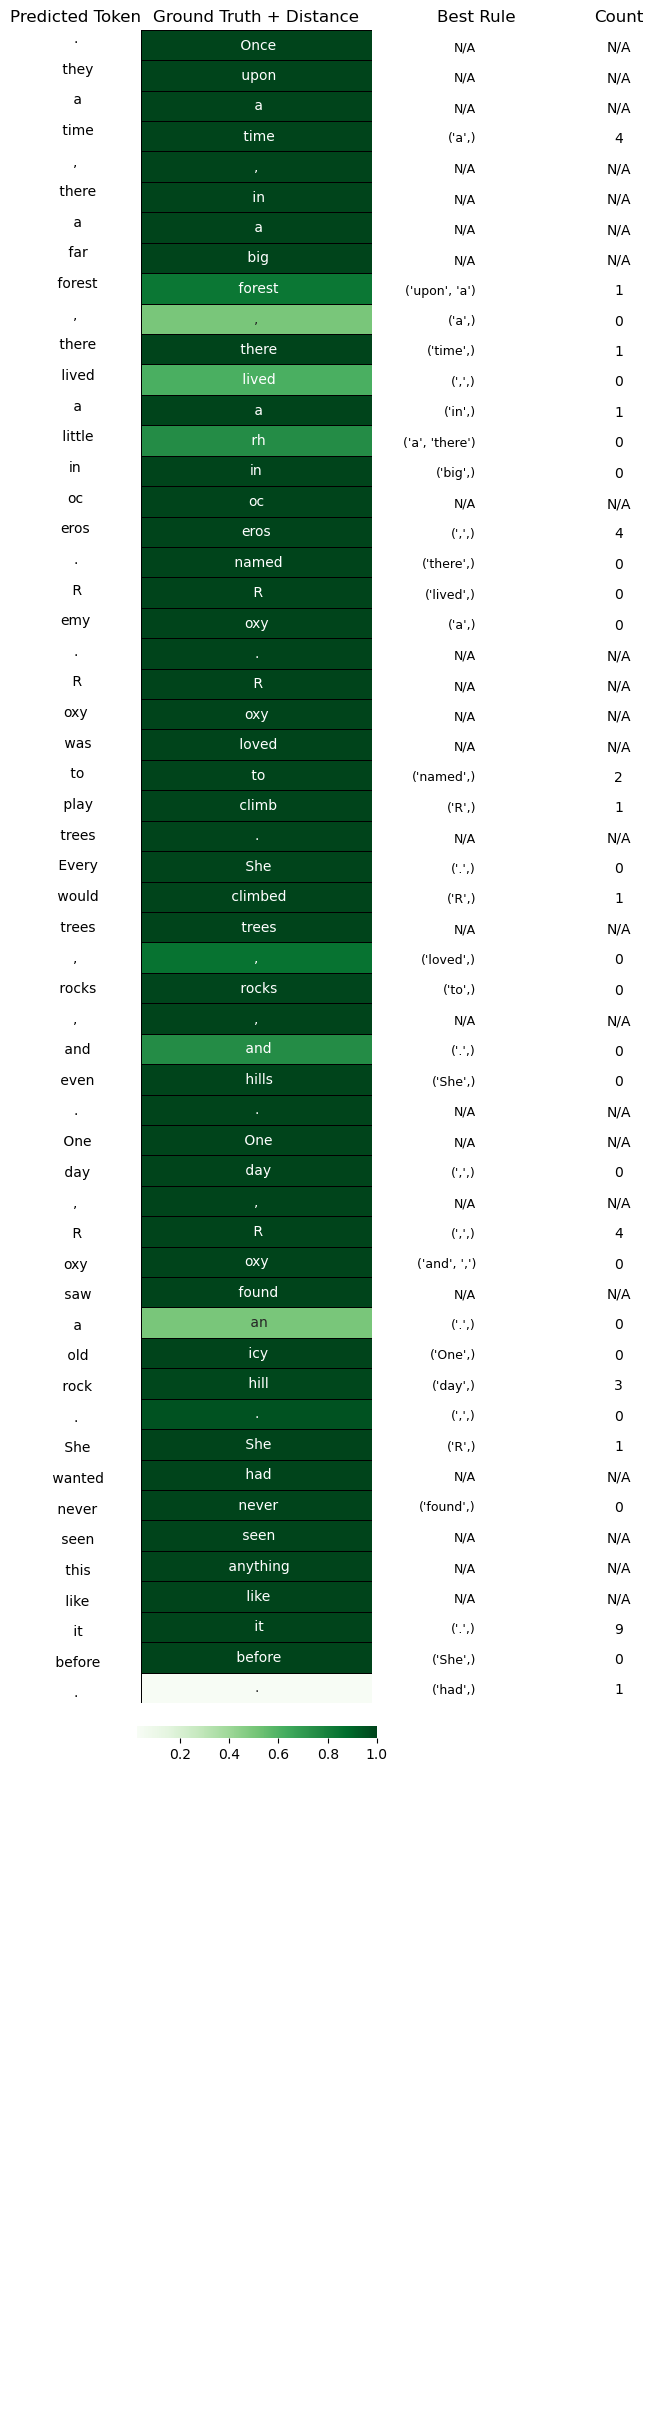

In [80]:
#Liste für die heatmap Daten Initialisierung
heatmap_data = []

# Iteriere durch alle Vorhersagen für den ersten Satz
for pred in all_predictions_final[0]:  # Nur erster Satz
    rule_context = pred.get("best_rule")
    context_count = pred.get("rule_context_count", "N/A")

    # Regelkontext als String-Tupel (ohne Wildcards)
    if rule_context and isinstance(rule_context[0], int):
        rule_context_tokens = []
        for tok in rule_context:
            if tok == 0:
                continue  # Wildcard einfach auslassen
            decoded = tokenizer.decode_ids([tok]).strip()
            rule_context_tokens.append(decoded)
        rule_context_str = str(tuple(rule_context_tokens))
    elif rule_context:
        rule_context_str = str(tuple(rule_context))
    else:
        rule_context_str = "N/A"


    # Kombiniere Regeltext + Count für die Anzeige rechts
    rule_info = f"{rule_context_str} (count: {context_count})"
    
    #vorhergesagtes Token und ground truth extrahieren
    predicted_token = pred.get("predicted_token", "").replace('_', '')
    ground_truth = pred.get("ground_truth", "").replace('_', '')
    distance = pred.get("variational_distance", None)
    #debugging
    #print(f"\n Check Token:")
    #print(f"Predicted: '{predicted_token}', Ground Truth: '{ground_truth}', Distance: {distance}")

     # Behandle 'inf' für Distanz (visuelles Signal, wenn keine Regel gefunden wurde)
    if distance is not None and np.isinf(distance):
        distance = 1.0
    # Füge nur Daten hinzu, wenn Vorhersage und Ground Truth vorhanden sind
    if predicted_token and ground_truth and distance is not None:
        heatmap_data.append({
            "predicted_token": predicted_token,
            "ground_truth": ground_truth,
            "difference": distance,
            "rule_context_str": rule_context_str,
            "rule_context_count": context_count
        })


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_variational_distance_with_predictions(heatmap_data, spacing_factor=0.71, rule_spacing_factor=0.71):
    """
    Visualisiert die Variational Distance zwischen Modellvorhersagen und Regeln.
    
    Parameter:
    - heatmap_data: Liste von Dictionaries, die die Heatmap-Daten enthalten.
    - spacing_factor: Einfluss auf den vertikalen Abstand der Textanzeigen.
    - rule_spacing_factor: Einfluss auf den vertikalen Abstand der Regeln.
    """

     # Bestimme die Anzahl der Zeilen basierend auf den Daten
    num_rows = len(heatmap_data)
    adjusted_rows = int(num_rows * max(spacing_factor, rule_spacing_factor))

    # Erstelle Subplots (4 Spalten)
    fig, axes = plt.subplots(1, 4, figsize=(8, adjusted_rows * 0.85), gridspec_kw={'width_ratios': [1, 3, 2, 1]})

    # Links: Predicted Tokens anzeigen
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(num_rows, 0)
    axes[0].axis("off")
    for i, token in enumerate([entry["predicted_token"] for entry in heatmap_data]):
        axes[0].text(0.5, i * spacing_factor + 0.2, token, ha="center", va="center", fontsize=10)
    axes[0].set_title("Predicted Token")

    # Mitte: Heatmap mit Ground Truth und Distanz
    distances = np.array([entry["difference"] for entry in heatmap_data]).reshape(-1, 1)
    ground_truths = np.array([[entry["ground_truth"]] for entry in heatmap_data])

    ax = sns.heatmap(distances, annot=ground_truths, fmt="", cmap="Greens", cbar=True, linewidths=0.5,
                      linecolor="black", xticklabels=False, yticklabels=False, cbar_kws={"orientation": "horizontal"},
                      ax=axes[1])

    axes[1].set_title("Ground Truth + Distance")

    # Rechts: Beste Regel (Spalte 3)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(num_rows, 0)
    axes[2].axis("off")
    for i, rule_str in enumerate([entry["rule_context_str"] for entry in heatmap_data]):
        axes[2].text(0.5, i * rule_spacing_factor + 0.4, rule_str, ha="right", va="center", fontsize=9)
    axes[2].set_title("Best Rule")

    # Ganz rechts: Count (Spalte 4)
    axes[3].set_xlim(0, 1)
    axes[3].set_ylim(num_rows, 0)
    axes[3].axis("off")
    for i, count in enumerate([str(entry["rule_context_count"]) for entry in heatmap_data]):
        axes[3].text(0.5, i * rule_spacing_factor + 0.4, count, ha="center", va="center", fontsize=10)
    axes[3].set_title("Count")

    # Farbskala positionieren
    cbar = ax.collections[0].colorbar
    fig.subplots_adjust(top=0.85)
    cbar.ax.set_position([0.25, 0.255, 0.30, 0.07])

    #plot speichern
    plt.savefig("variational_distance_plot1.pdf", bbox_inches='tight', dpi=300)


    #Plot zeigen
    plt.show()



plot_variational_distance_with_predictions(heatmap_data, spacing_factor=0.705, rule_spacing_factor=0.70)





# Tests

In [52]:
# Zeige alle Regel-Kontexte mit P > 0
for entry in all_probabilities:
    for rule_context, prob in entry['rule_probs']:
        if prob > 0.0:
            print(f"Token-{entry['token_index']} (ID: {entry['token_id']})")
            print(f"Regelkontext: {rule_context} → P = {prob:.4f}")
            print("-" * 40)


Token-2 (ID: 275)
Regelkontext: (1726, 616, 32600, 0) → P = 0.5000
----------------------------------------
Token-2 (ID: 275)
Regelkontext: (1726, 275, 616, 0) → P = 1.0000
----------------------------------------
Token-2 (ID: 275)
Regelkontext: (32600,) → P = 0.2500
----------------------------------------
Token-3 (ID: 1572)
Regelkontext: (616, 32600, 0, 275) → P = 1.0000
----------------------------------------
Token-3 (ID: 1572)
Regelkontext: (32600, 0) → P = 0.1111
----------------------------------------
Token-5 (ID: 32600)
Regelkontext: (275, 0) → P = 0.5000
----------------------------------------
Token-8 (ID: 275)
Regelkontext: (32600,) → P = 0.2500
----------------------------------------
Token-19 (ID: 4064)
Regelkontext: (3965, 0, 0, 0) → P = 0.5000
----------------------------------------
Token-20 (ID: 306)
Regelkontext: (32599, 0, 0, 0) → P = 0.1667
----------------------------------------
Token-20 (ID: 306)
Regelkontext: (32599, 0) → P = 0.1429
----------------------------

In [65]:
n = 7
official_counts = official_data[official_data['context_size_used'] == n]['target'].values
print("Beispielwerte:", official_counts[:20])
print("Min:", min(official_counts), "Max:", max(official_counts))
print("Anzahl official_counts:", len(official_counts))
print("Erste 20 Werte:", official_counts[:20])
from collections import Counter
count_counter = Counter(official_counts)
print("Top 10 häufigste Häufigkeiten:", count_counter.most_common(10))


Beispielwerte: [  305   429   275 32599   364 14164 10521   305   556   517  1724 32600
 32599 32600   364  2883  4343  2337 32599  2337]
Min: 4 Max: 32694
Anzahl official_counts: 4838
Erste 20 Werte: [  305   429   275 32599   364 14164 10521   305   556   517  1724 32600
 32599 32600   364  2883  4343  2337 32599  2337]
Top 10 häufigste Häufigkeiten: [(np.int64(32599), 285), (np.int64(280), 215), (np.int64(305), 205), (np.int64(32600), 188), (np.int64(4), 136), (np.int64(383), 135), (np.int64(275), 109), (np.int64(306), 108), (np.int64(610), 78), (np.int64(517), 73)]


In [66]:
print("Anzahl gezählter 7-Gramme:", len(ngram_counts[7]))
print("Einzigartige Häufigkeiten:", set(ngram_counts))
# Berechne die Verteilung der Häufigkeiten
print("Gesamtzahl Tokens:", len(tokens))


computed_counts = [count for count in ngram_counts[7].values()]
print("Einzigartige Häufigkeiten der berechneten 7-Gramme:", set(computed_counts))
print("Anzahl gezählter 7-Gramme:", len(computed_counts))


Anzahl gezählter 7-Gramme: 8531
Einzigartige Häufigkeiten: {1, 2, 3, 4, 5, 6, 7}
Gesamtzahl Tokens: 8537
Einzigartige Häufigkeiten der berechneten 7-Gramme: {1}
Anzahl gezählter 7-Gramme: 8531
